In [2]:
# data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

# !wget $data -O data-week-4.csv 

# Evaluation Metrics for Classification
*Metric* - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [5]:
df = pd.read_csv('data-week-4.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [7]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [8]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [9]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

### Accuracy and dummy model

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines
* Accuracy - fraction of correct answers - might be misleading

In [10]:
len(y_val)

1409

In [11]:
(y_val == churn_decision).mean()

0.8034066713981547

In [12]:
# total correct predictions
(y_val == churn_decision).sum()

1132

In [13]:
1132/1409

# ~80% accuracy for model 

0.8034066713981547

In [14]:
thresholds = np.linspace(0, 1, 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [15]:
# Can use already built solution - no need to implement ourselves

from sklearn.metrics import accuracy_score

In [16]:
scores = []

for t in thresholds:
    # churn_decision = (y_pred >= t)
    # score = (y_val == churn_decision).mean()
    score = accuracy_score(y_val, y_pred >= t)
    print(f"{t:.2f} {score:.3f}")
    scores.append(score)


0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


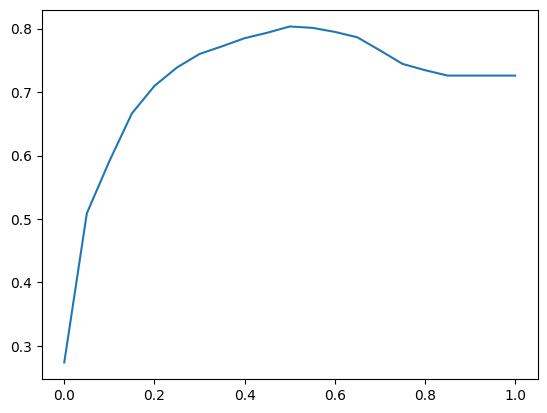

In [17]:
plt.plot(thresholds, scores)

In [18]:
from collections import Counter
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [19]:
# Distribution of our **y** or target data
# 1023 NON churning and 386 churning
# ^^^ THis is Class imbalance, as we have ~3x more non-churning as churning
# For models that have clas imbalance accuracy can be misleading

print(Counter(y_val))


print(y_val.mean())

print(1 - y_val.mean())  # Exactly the same accuracy as the plot shows
# if we predict all as non churning

Counter({0: 1023, 1: 386})
0.2739531582682754
0.7260468417317246


# Confusion table
* Different types of errors and correct decisions
* Arranging them in a table

In [20]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)


In [21]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)


In [22]:
actual_positive[:5]

array([False, False, False,  True, False])

In [23]:
true_positive = (predict_positive & actual_positive).sum()
true_positive

210

In [24]:
true_negative = (predict_negative & actual_negative).sum()
true_negative

922

In [25]:
false_positive = (predict_positive & actual_negative).sum()
false_positive

101

In [26]:
false_negative = (predict_negative & actual_positive).sum()
false_negative

176

In [27]:
confusion_matrix = np.array([
    [true_negative, false_positive],
    [false_negative, true_positive]
])
confusion_matrix 

array([[922, 101],
       [176, 210]])

In [28]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## Precision and Recall
- more evaluation metrics that can be retrieved using confusion matrix

In [29]:
accuracy = (
    (true_negative + true_positive) 
    /
    (true_negative + false_negative + false_positive + true_positive)
)
accuracy

0.8034066713981547

### **precision** 
Fraction of positive predictions that are correct


### **recall** 
Fraction of churning users that we identified correctly
(fraction of correctly identified positive examples)

In [30]:
# Fraction of positive predictions that are correct
precision = true_positive / (true_positive + false_positive)
precision

# 0.675 --> this tells us that ~ 33% was a mistake - people didnt churn
# and 67% were correct

0.6752411575562701

In [31]:
# Fraction of churning users that we identified correctly
recall = true_positive / (true_positive + false_negative)
recall

# 0.544 --> this tells us that ~ 46% was a mistake - 
# we didn't identify churning users

0.5440414507772021

In [32]:
# Accuracy is not the best way to evalueate model, as accuracy might be 80%
# but for example recall shows that we correctlyy identifief only 54% of
# churning users

# Eavualuate both of these especially important
# when dataset has class imbalance

## ROC Curves
Receiver Operating Characteristics - 
- describes the performance of a binary classification model

### TPR and FRP
- True Positive Rate
- False Positive Rate
Both derived from values from confusion matrix

In [33]:
# FPR - True Negative and False Positive (first row of confusion matrix)
fpr = false_positive / (true_negative + false_positive)
# Should be as little as possible
# For all negative values - ~ 10% are still predicted incorrectly
fpr

0.09872922776148582

In [34]:
# TPR - False Negative and True Positive(second row from confusion matrix)
tpr = true_positive / (false_negative + true_positive)
# Should be as big as possible
tpr

0.5440414507772021

In [35]:
thresholds = np.linspace(0,1, 101)


actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

scores = []

for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    true_positive = (predict_positive & actual_positive).sum()
    true_negative = (predict_negative & actual_negative).sum()
    false_positive = (predict_positive & actual_negative).sum()
    false_negative = (predict_negative & actual_positive).sum()
    scores.append(
        (t, true_positive, false_positive, false_negative, true_negative)
    )

In [36]:
columns = [
    "threshold",
    "true_positive",
    "false_positive",
    "false_negative",
    "true_negative",
]
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[::10]

,threshold,true_positive,false_positive,false_negative,true_negative
0,0.0,386,1023,0,0
10,0.1,366,556,20,467
20,0.2,333,356,53,667
30,0.3,284,236,102,787
40,0.4,249,166,137,857
50,0.5,210,101,176,922
60,0.6,150,53,236,970
70,0.7,76,20,310,1003
80,0.8,13,1,373,1022
90,0.9,0,0,386,1023


In [37]:
df_scores["tpr"] = (
    df_scores.true_positive / 
    (df_scores.false_negative + df_scores.true_positive)
)
df_scores["fpr"] = (
    df_scores.false_positive / 
    (df_scores.true_negative + df_scores.false_positive)
)

df_scores[::10]

,threshold,true_positive,false_positive,false_negative,true_negative,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,556,20,467,0.948187,0.543500
20,0.2,333,356,53,667,0.862694,0.347996
30,0.3,284,236,102,787,0.735751,0.230694
40,0.4,249,166,137,857,0.645078,0.162268
50,0.5,210,101,176,922,0.544041,0.098729
60,0.6,150,53,236,970,0.388601,0.051808
70,0.7,76,20,310,1003,0.196891,0.019550
80,0.8,13,1,373,1022,0.033679,0.000978
90,0.9,0,0,386,1023,0.000000,0.000000


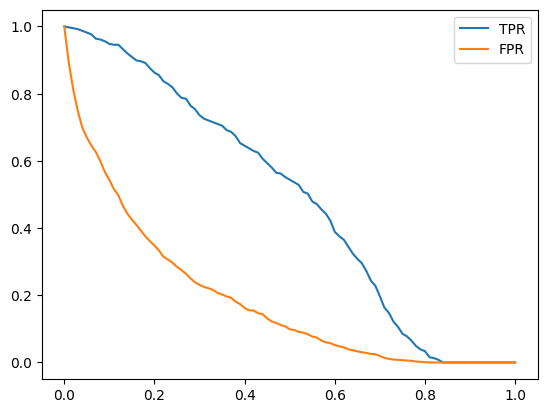

In [38]:
plt.plot(df_scores.threshold, df_scores.tpr, label="TPR")
plt.plot(df_scores.threshold, df_scores.fpr, label="FPR")
plt.legend()

## Random model
Compare our model to a random model to have something to compare it to

In [39]:
np.random.seed(1)
y_rand = np.random.uniform(0,1,size=len(y_val))
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089])

In [40]:
# 50% is expected, just by "luck" predicted correctly
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [41]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0,1, 101)


    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)


    for t in thresholds:
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        true_positive = (predict_positive & actual_positive).sum()
        true_negative = (predict_negative & actual_negative).sum()
        false_positive = (predict_positive & actual_negative).sum()
        false_negative = (predict_negative & actual_positive).sum()
        scores.append(
            (t, true_positive, false_positive, false_negative, true_negative)
        )
    columns = [
    "threshold",
    "true_positive",
    "false_positive",
    "false_negative",
    "true_negative",
    ]
    df_scores = pd.DataFrame(scores, columns=columns)
    df_scores["tpr"] = (
        df_scores.true_positive / 
        (df_scores.false_negative + df_scores.true_positive)
    )
    df_scores["fpr"] = (
        df_scores.false_positive / 
        (df_scores.true_negative + df_scores.false_positive)
    )
    return df_scores


In [42]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,threshold,true_positive,false_positive,false_negative,true_negative,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


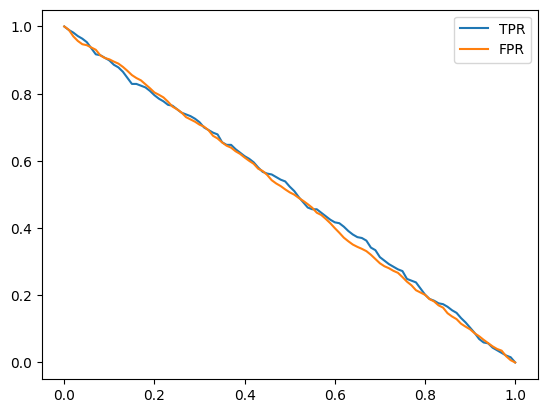

In [43]:
plt.plot(df_rand.threshold, df_rand.tpr, label="TPR")
plt.plot(df_rand.threshold, df_rand.fpr, label="FPR")
plt.legend()

### Ideal model

In [44]:
num_neg = (y_val ==0).sum()
num_pos = (y_val ==1).sum()
num_neg, num_pos

(1023, 386)

In [45]:
y_ideal = np.repeat([0,1],[num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [46]:
y_ideal_pred = np.linspace(0,1, len(y_val))

In [47]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [48]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,true_positive,false_positive,false_negative,true_negative,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


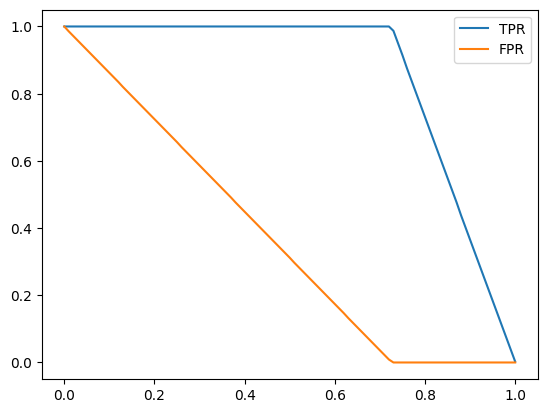

In [49]:
plt.plot(df_ideal.threshold, df_ideal.tpr, label="TPR")
plt.plot(df_ideal.threshold, df_ideal.fpr, label="FPR")
plt.legend()

### Puttting everything togetheer
Plot all models

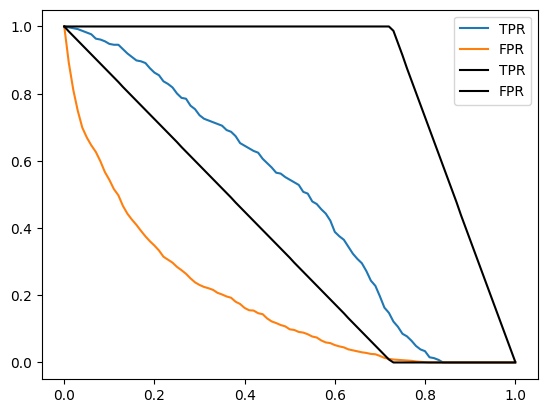

In [50]:
plt.plot(df_scores.threshold, df_scores.tpr, label="TPR")
plt.plot(df_scores.threshold, df_scores.fpr, label="FPR")

# plt.plot(df_rand.threshold, df_rand.tpr, label="TPR")
# plt.plot(df_rand.threshold, df_rand.fpr, label="FPR")

plt.plot(df_ideal.threshold, df_ideal.tpr, label="TPR", color="black")
plt.plot(df_ideal.threshold, df_ideal.fpr, label="FPR", color="black")


plt.legend()

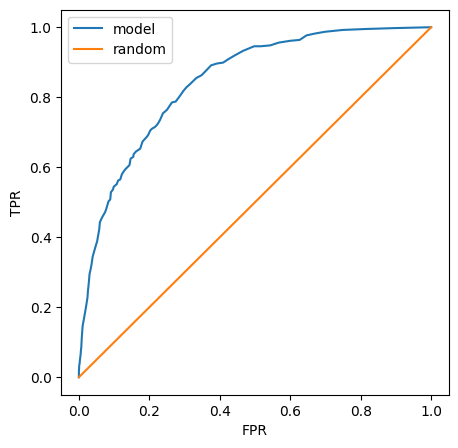

In [51]:
plt.figure(figsize=(5,5))

plt.plot(df_scores.fpr, df_scores.tpr, label="model")

# Instead of plotting the random - can just plot a line from 0 to 1
# plt.plot(df_rand.fpr, df_rand.tpr, label="random")
plt.plot([0,1], [0,1], label="random")

# No need to plot ideal one - already know how it looks
# plt.plot(df_ideal.fpr, df_ideal.tpr, label="ideal")


plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

# We want to be as close as possible to left upper corner - ideal spot
# with the model curve<<


If model curve goes BELOW the random curve - then ww do smth worng and probably we have to flip positive and negative predictions

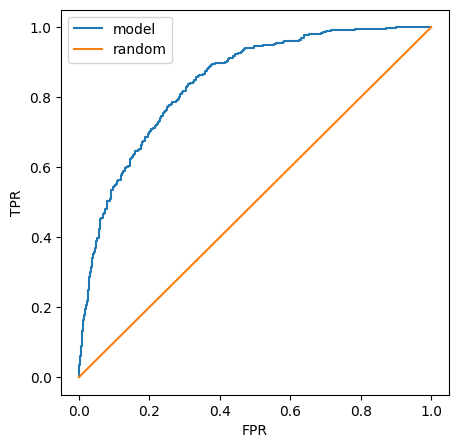

In [52]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

# plot ROC curve with sklearn evaluated FPR and TPR

plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label="model")
plt.plot([0,1], [0,1], label="random")

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

## ROC AUC

* Area under the ROC curve - useful metric
* Interpretation of AUC
* MEasures how close are we to the "ideal point" with the model
* And how well the model separates the positive and negative classes
* (if all positive classes have higher score - perfect score)

In [53]:
# THese are the baselines

# AUC for random is 0.5
# AUC for ideal curve is 1

In [54]:
from sklearn.metrics import auc
# can calc any area under any curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr) 


0.8438530381535563

In [55]:
auc(df_scores.fpr, df_scores.tpr)
# Reasomably accurate also the ones we calculated ourselves (to the 4th digit)

0.8438732975754537

In [56]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)



0.8438530381535563

In [57]:
neg = y_pred[y_val ==0]
pos = y_pred[y_val ==1]



In [58]:
import random

n = 10000
success = 0
for i in range(n):
    pos_idx = random.randint(0, len(pos) - 1)
    neg_idx = random.randint(0, len(neg) - 1)

    if pos[pos_idx] > neg[neg_idx]:
        success += 1

success / n

0.8477

In [59]:
n = 10000
np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)


In [60]:
(pos[pos_ind] > neg[neg_ind]).mean()

0.8412


#### ^^^ AUC interpretation
AUC tells us the probability that a randomly selected positive
example has a higher score than a randomly selected negative example


## **Cross-Validation**

* Evaluating the same model on different subsets of data
* Getting the average prediction and the spread within predictions
* SPlit full_train and test dataset
* Then split the full_train into K-fold datasets (K=3, then split to 3 parts or "folds")
* THen intercombine 2 out of three K-folds and validate it with the one that's left and calculate AUC for that.
* e.g. (TRAIN (1,2) -> VAL (3)) ; (TRAIN (1,3) -> VAL (2)); etc.

In [77]:
def train (df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient="records")

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    # parameter tuning - for LogisticRegression it' s "C'
    #  - equivalent to regularization. 1.0 is default
    # Smaller values specify stronger regularization - contary to normal equation
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

In [75]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient="records")
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [63]:
predict(df_val, dv, model)

array([0.00899601, 0.20452832, 0.21222782, ..., 0.13638515, 0.79976953,
       0.83740745])

In [64]:
from tqdm.auto import tqdm
tqdm()

0it [00:00, ?it/s]

In [81]:
from sklearn.model_selection import KFold
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    scores = []

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        #  TOTAL NO. of ITERATIONS REACHED LIMIT. warning allegedly can be ignored
    print("%s %.3f += %.3f" % (C, np.mean(scores), np.std(scores)))
    # STD - "spread"

  0%|          | 0/7 [00:00<?, ?it/s]

0.001 0.825 += 0.009
0.01 0.840 += 0.009
0.1 0.842 += 0.008
0.5 0.840 += 0.006
1 0.841 += 0.008
5 0.841 += 0.007
10 0.842 += 0.007


Choose best option for C - default is 1 and it' s "good enough"

now need ot train full model

In [82]:


dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)
auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259

### WHen to use cross validation and when the regular hold out
Most of the time holdout works, especially if the dataset is large. (week 2 and 3)

If dataset is smaller or if you also want to have standard deviation to understand how stable the model is and how much it varies across different fold,then can use cross valdiation.
For bigger datasets the K could be 2 or 3 but for smaller dataset more splits - K=10 or smth like that.